# Часть 1 Бустинг (5 баллов)

В этой части будем предсказывать зарплату data scientist-ов в зависимости  от ряда факторов с помощью градиентного бустинга.

В датасете есть следующие признаки:



* work_year: The number of years of work experience in the field of data science.

* experience_level: The level of experience, such as Junior, Senior, or Lead.

* employment_type: The type of employment, such as Full-time or Contract.

* job_title: The specific job title or role, such as Data Analyst or Data Scientist.

* salary: The salary amount for the given job.

* salary_currency: The currency in which the salary is denoted.

* salary_in_usd: The equivalent salary amount converted to US dollars (USD) for comparison purposes.

* employee_residence: The country or region where the employee resides.

* remote_ratio: The percentage of remote work offered in the job.

* company_location: The location of the company or organization.

* company_size: The company's size is categorized as Small, Medium, or Large.

In [62]:
import pandas as pd
import numpy as np

df = pd.read_csv("ds_salaries.txt")
df.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,SE,FT,Principal Data Scientist,80000,EUR,85847,ES,100,ES,L
1,2023,MI,CT,ML Engineer,30000,USD,30000,US,100,US,S
2,2023,MI,CT,ML Engineer,25500,USD,25500,US,100,US,S
3,2023,SE,FT,Data Scientist,175000,USD,175000,CA,100,CA,M
4,2023,SE,FT,Data Scientist,120000,USD,120000,CA,100,CA,M


## Задание 1 (0.5 балла) Подготовка



*   Разделите выборку на train, val, test (80%, 10%, 10%)
*   Выдерите salary_in_usd в качестве таргета
*   Найдите и удалите признак, из-за которого возможен лик в данных


## Задание 2 (0.5 балла) Линейная модель


*   Закодируйте категориальные  признаки с помощью OneHotEncoder
*   Обучите модель линейной регрессии
*   Оцените  качество через MAPE и RMSE


Сначала закодирую признаки, а потом уже разобью все это дело на train, val, test

In [63]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

mapes_test = []
rmses_test = []

categorical_columns = df.select_dtypes(include=['object']).columns.tolist()
encoder = OneHotEncoder(sparse_output=False)
encoded = encoder.fit_transform(df[categorical_columns])

encoded = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(categorical_columns))

df_encoded = pd.concat([df.drop(categorical_columns, axis=1), encoded], axis=1)

y = df_encoded['salary_in_usd']
X = df_encoded.drop(['salary_in_usd', 'salary'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
pred = lin_reg.predict(X_test)

mapes_test.append(mean_absolute_percentage_error(y_test, pred))
rmses_test.append(np.sqrt(mean_squared_error(y_test, pred)))

print('MAPE: ', mean_absolute_percentage_error(y_test, pred))
print('RMSE: ', np.sqrt(mean_squared_error(y_test, pred)))

MAPE:  18842285.34194802
RMSE:  7247339063735.152


Немного кода взяла [отсюда](https://www.geeksforgeeks.org/ml-one-hot-encoding/)

## Задание 3 (0.5 балла) XGboost

Начнем с библиотеки xgboost.

Обучите модель `XGBRegressor` на тех же данных, что линейную модель, подобрав оптимальные гиперпараметры (`max_depth, learning_rate, n_estimators, gamma`, etc.) по валидационной выборке. Оцените качество итоговой модели (MAPE, RMSE), скорость обучения и скорость предсказания.

In [9]:
from xgboost.sklearn import XGBRegressor

params = {
    'max_depth' : [5, 7, 10, 15, 30, 50] ,
    'learning_rate' : np.linspace(1e-2, 0.3, 50),
    'n_estimators' : [50, 75, 100, 150, 200],
    'gamma' : np.linspace(0.001, 0.5, 50),
}

best_mape = np.inf
best_rmse = np.inf

best_max_depth = 0
best_learning_rate = 0
best_n_estimators = 0
best_gamma = 0

for max_depth in params['max_depth']:
  for learning_rate in params['learning_rate']:
    for n_estimators in params['n_estimators']:
      for gamma in params['gamma']:
        model = XGBRegressor(max_depth = max_depth, learning_rate=learning_rate, n_estimators=n_estimators, gamma=gamma)
        model.fit(X_train, y_train)
        pred = model.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, pred))
        mape = mean_absolute_percentage_error(y_val, pred)
        if rmse < best_rmse and mape < best_mape:
          best_rmse, best_mape = rmse, mape
          best_max_depth = max_depth
          best_learning_rate = learning_rate
          best_n_estimators = n_estimators
          best_gamma = gamma
          print(rmse, mape, max_depth, learning_rate, n_estimators)

52800.08660599702 0.6792966853577441 5 0.01 50
50452.473115424116 0.6158109660596427 5 0.01 75
48999.69127127131 0.5682736199085872 5 0.01 100
47435.532366904714 0.5018165194506986 5 0.01 150


KeyboardInterrupt: 

Изначально пыталась циклом, однако это очень долго, код сверху оставила, далее подбирала параметры точечным прогоном...

In [64]:
from xgboost.sklearn import XGBRegressor

model = XGBRegressor(max_depth = 5, learning_rate=1e-1, n_estimators=100, gamma=0.1)
model.fit(X_train, y_train)
pred = model.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, pred))
mape = mean_absolute_percentage_error(y_val, pred)
rmse, mape

(45539.590782184656, 0.3862759399710152)

In [65]:
%%time
model = XGBRegressor(max_depth = 5, learning_rate=1e-1, n_estimators=100, gamma=0.1)
model.fit(X_train, y_train)

CPU times: user 1.72 s, sys: 12.8 ms, total: 1.73 s
Wall time: 1.66 s


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.1, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [67]:
%%time
pred = model.predict(X_test)

mapes_test.append(mean_absolute_percentage_error(y_test, pred))
rmses_test.append(np.sqrt(mean_squared_error(y_test, pred)))

print('MAPE: ', mean_absolute_percentage_error(y_test, pred))
print('RMSE: ', np.sqrt(mean_squared_error(y_test, pred)))

MAPE:  0.3369790673768235
RMSE:  50215.030794760176
CPU times: user 44.7 ms, sys: 990 µs, total: 45.7 ms
Wall time: 42.6 ms


## Задание 4 (1 балл) CatBoost

Теперь библиотека CatBoost.

Обучите модель `CatBoostRegressor`, подобрав оптимальные гиперпараметры (`depth, learning_rate, iterations`, etc.) по валидационной выборке. Оцените качество итоговой модели (MAPE, RMSE), скорость обучения и скорость предсказания.

In [22]:
!pip install catboost
from catboost import CatBoostRegressor

  Using cached catboost-1.2.5-cp310-cp310-manylinux2014_x86_64.whl (98.2 MB)


In [34]:
cbr = CatBoostRegressor(learning_rate=1e-1, depth=5, iterations=500)
cbr.fit(X_train, y_train)
pred = cbr.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, pred))
mape = mean_absolute_percentage_error(y_val, pred)
rmse, mape

0:	learn: 61148.3711580	total: 1.29ms	remaining: 645ms
1:	learn: 59309.1362578	total: 3.2ms	remaining: 797ms
2:	learn: 57904.6786621	total: 4.71ms	remaining: 780ms
3:	learn: 56669.5437669	total: 6.2ms	remaining: 769ms
4:	learn: 55643.5760969	total: 7.94ms	remaining: 786ms
5:	learn: 54772.1188071	total: 9.62ms	remaining: 792ms
6:	learn: 53912.0972970	total: 11.4ms	remaining: 800ms
7:	learn: 53192.5555370	total: 12.6ms	remaining: 775ms
8:	learn: 52648.1087685	total: 14.1ms	remaining: 769ms
9:	learn: 52091.7028124	total: 15.6ms	remaining: 764ms
10:	learn: 51694.4416615	total: 17.1ms	remaining: 758ms
11:	learn: 51333.0988501	total: 18.5ms	remaining: 754ms
12:	learn: 50999.5223555	total: 20ms	remaining: 747ms
13:	learn: 50662.2057164	total: 21.7ms	remaining: 753ms
14:	learn: 50394.1327687	total: 23.2ms	remaining: 750ms
15:	learn: 50177.8484625	total: 24.6ms	remaining: 744ms
16:	learn: 49957.6741356	total: 27ms	remaining: 767ms
17:	learn: 49815.7472279	total: 28ms	remaining: 749ms
18:	learn:

(44889.60901898548, 0.38184792394797806)

In [68]:
%%time
cbr = CatBoostRegressor(learning_rate=1e-1, depth=5, iterations=500)
cbr.fit(X_train, y_train)

0:	learn: 61148.3711580	total: 1.5ms	remaining: 749ms
1:	learn: 59309.1362578	total: 4.19ms	remaining: 1.04s
2:	learn: 57904.6786621	total: 5.53ms	remaining: 916ms
3:	learn: 56669.5437669	total: 7.09ms	remaining: 880ms
4:	learn: 55643.5760969	total: 8.62ms	remaining: 854ms
5:	learn: 54772.1188071	total: 10.1ms	remaining: 831ms
6:	learn: 53912.0972970	total: 11.6ms	remaining: 817ms
7:	learn: 53192.5555370	total: 13.1ms	remaining: 803ms
8:	learn: 52648.1087685	total: 15.1ms	remaining: 825ms
9:	learn: 52091.7028124	total: 16.5ms	remaining: 808ms
10:	learn: 51694.4416615	total: 18ms	remaining: 802ms
11:	learn: 51333.0988501	total: 19.6ms	remaining: 795ms
12:	learn: 50999.5223555	total: 21ms	remaining: 788ms
13:	learn: 50662.2057164	total: 22.5ms	remaining: 782ms
14:	learn: 50394.1327687	total: 24ms	remaining: 775ms
15:	learn: 50177.8484625	total: 25.5ms	remaining: 772ms
16:	learn: 49957.6741356	total: 27.1ms	remaining: 769ms
17:	learn: 49815.7472279	total: 28.4ms	remaining: 760ms
18:	learn

In [69]:
%%time
pred = cbr.predict(X_test)
mapes_test.append(mean_absolute_percentage_error(y_test, pred))
rmses_test.append(np.sqrt(mean_squared_error(y_test, pred)))
print('MAPE: ', mean_absolute_percentage_error(y_test, pred))
print('RMSE: ', np.sqrt(mean_squared_error(y_test, pred)))

MAPE:  0.3352756334129914
RMSE:  50099.23388683385
CPU times: user 33.4 ms, sys: 1.98 ms, total: 35.3 ms
Wall time: 55.6 ms


Для применения catboost моделей не обязательно сначала кодировать категориальные признаки, модель может кодировать их сама. Обучите catboost с подбором оптимальных гиперпараметров снова, используя pool для передачи данных в модель с указанием какие признаки категориальные, а какие нет с помощью параметра cat_features. Оцените качество и время. Стало ли лучше?

In [70]:
from catboost import Pool

y_pool = df['salary_in_usd']
X_pool = df.drop(['salary_in_usd', 'salary'], axis=1)
X_train_pool, X_test_pool, y_train_pool, y_test_pool = train_test_split(X_pool, y_pool, test_size=0.2, random_state=42)
X_val_pool, X_test_pool, y_val_pool, y_test_pool = train_test_split(X_test_pool, y_test_pool, test_size=0.5, random_state=42)

train_data = Pool(data=X_train_pool, label=y_train_pool, cat_features=categorical_columns)

cbr = CatBoostRegressor(learning_rate=1e-1, depth=5, iterations=250)
cbr.fit(train_data)
pred = cbr.predict(X_val_pool)


print('MAPE: ', mean_absolute_percentage_error(y_val_pool, pred))
print('RMSE: ', np.sqrt(mean_squared_error(y_val_pool, pred)))

0:	learn: 61258.7550726	total: 5.15ms	remaining: 1.28s
1:	learn: 59594.6750200	total: 11.1ms	remaining: 1.37s
2:	learn: 58347.5713036	total: 13.7ms	remaining: 1.13s
3:	learn: 57323.3481866	total: 15.6ms	remaining: 957ms
4:	learn: 56437.2073052	total: 20.7ms	remaining: 1.01s
5:	learn: 55583.3232656	total: 24.6ms	remaining: 999ms
6:	learn: 54711.9244770	total: 28.3ms	remaining: 982ms
7:	learn: 53947.0254104	total: 32.1ms	remaining: 972ms
8:	learn: 53159.5302564	total: 36.3ms	remaining: 972ms
9:	learn: 52520.7285591	total: 40.4ms	remaining: 968ms
10:	learn: 51969.5361599	total: 43.6ms	remaining: 948ms
11:	learn: 51493.4283016	total: 47.2ms	remaining: 936ms
12:	learn: 51080.6963065	total: 51ms	remaining: 930ms
13:	learn: 50737.2304765	total: 55.2ms	remaining: 930ms
14:	learn: 50407.2713274	total: 58.8ms	remaining: 921ms
15:	learn: 50143.3129018	total: 62.6ms	remaining: 916ms
16:	learn: 49858.1089859	total: 66.3ms	remaining: 909ms
17:	learn: 49758.6733668	total: 68.2ms	remaining: 880ms
18:	

In [71]:
%%time
cbr = CatBoostRegressor(learning_rate=1e-1, depth=5, iterations=250)
cbr.fit(train_data)

0:	learn: 61258.7550726	total: 6.4ms	remaining: 1.59s
1:	learn: 59594.6750200	total: 14.2ms	remaining: 1.76s
2:	learn: 58347.5713036	total: 16.3ms	remaining: 1.34s
3:	learn: 57323.3481866	total: 18.2ms	remaining: 1.12s
4:	learn: 56437.2073052	total: 22.8ms	remaining: 1.12s
5:	learn: 55583.3232656	total: 27.1ms	remaining: 1.1s
6:	learn: 54711.9244770	total: 30.8ms	remaining: 1.07s
7:	learn: 53947.0254104	total: 34.8ms	remaining: 1.05s
8:	learn: 53159.5302564	total: 39ms	remaining: 1.04s
9:	learn: 52520.7285591	total: 43.3ms	remaining: 1.04s
10:	learn: 51969.5361599	total: 47ms	remaining: 1.02s
11:	learn: 51493.4283016	total: 50.6ms	remaining: 1s
12:	learn: 51080.6963065	total: 54.3ms	remaining: 990ms
13:	learn: 50737.2304765	total: 57.5ms	remaining: 969ms
14:	learn: 50407.2713274	total: 61.2ms	remaining: 959ms
15:	learn: 50143.3129018	total: 65.1ms	remaining: 952ms
16:	learn: 49858.1089859	total: 68.9ms	remaining: 944ms
17:	learn: 49758.6733668	total: 70.9ms	remaining: 914ms
18:	learn: 

In [72]:
%%time
pred = cbr.predict(X_test_pool)

mapes_test.append(mean_absolute_percentage_error(y_test, pred))
rmses_test.append(np.sqrt(mean_squared_error(y_test, pred)))

print('MAPE: ', mean_absolute_percentage_error(y_test_pool, pred))
print('RMSE: ', np.sqrt(mean_squared_error(y_test_pool, pred)))

MAPE:  0.346487290197102
RMSE:  49957.64578458699
CPU times: user 9.96 ms, sys: 1 ms, total: 11 ms
Wall time: 11.6 ms


**Ответ:** ошибка практически такая же, скорее всего если получше поискать гиперпараметры, то можно побить предыдущий score, поэтому использование Pool в Catboost достаточно актуально, как минимум с точки зрения практичности и ненагромождения кода

## Задание 5 (0.5 балла) LightGBM

И наконец библиотека LightGBM - используйте `LGBMRegressor`, снова подберите гиперпараметры, оцените качество и скорость.


In [74]:
from lightgbm import LGBMRegressor

In [82]:
lgbm = LGBMRegressor(max_depth=10, learning_rate=1e-1, n_estimators=50)
lgbm.fit(X_train, y_train)
pred = lgbm.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, pred))
mape = mean_absolute_percentage_error(y_val, pred)
rmse, mape

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000995 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 3004, number of used features: 41
[LightGBM] [Info] Start training from score 138055.989348
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fur

(46192.76126358439, 0.3986387066684651)

In [83]:
%%time
lgbm = LGBMRegressor(max_depth=10, learning_rate=1e-1, n_estimators=50)
lgbm.fit(X_train, y_train)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001142 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 3004, number of used features: 41
[LightGBM] [Info] Start training from score 138055.989348
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fur

LGBMRegressor(max_depth=10, n_estimators=50)

In [87]:
%%time
pred = lgbm.predict(X_test)

mapes_test.append(mean_absolute_percentage_error(y_test, pred))
rmses_test.append(np.sqrt(mean_squared_error(y_test, pred)))

print('MAPE: ', mean_absolute_percentage_error(y_test, pred))
print('RMSE: ', np.sqrt(mean_squared_error(y_test, pred)))

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
MAPE:  0.322709430052716
RMSE:  49555.972955656754
CPU times: user 14.9 ms, sys: 0 ns, total: 14.9 ms
Wall time: 14.7 ms


## Задание 6 (2 балла) Сравнение и выводы

Сравните модели бустинга и сделайте про них выводы, какая из моделей показала лучший/худший результат по качеству, скорости обучения и скорости предсказания? Как отличаются гиперпараметры для разных моделей?

In [86]:
models = ['Lin_reg', 'XGB', 'Catboost', 'Catboost_Pool', 'LightGBM']
index = ['MAPE', 'RMSE']
pd.DataFrame([mapes_test, rmses_test], columns=models, index=index)

,Lin_reg,XGB,Catboost,Catboost_Pool,LightGBM
MAPE,1.884229e+07,0.336979,0.335276,0.346487,0.322709
RMSE,7.247339e+12,50215.030795,50099.233887,49957.645785,49555.972956


**Ответ:**

1. Сразу видно, что любой бустинг работает гораздо лучше по качеству, чем простая линейная регрессия

2. По качеству самая лучшая **LightGBM**, худшая - **Catboost_Pool** или **XGB**

3. По скорости обучения: лучшая - **LightGBM**, худшая - **XGB**

4. По скорости предсказания: лучшая - **Catboost_Pool**, худшая - **Catboost**

В целом, нужно отметить, что для регресии относительно неглубокие деревья, их количество несильно большое, иначе происходит переобучение.
Везде одинаковый градиентный шаг, у Catboost относительно большое количество деревьев, а вот у LigthGBM наоборот. Зато у LightGBM деревья глубже в два раза, чем деревья у других моделей.

# Часть 2 Кластеризация (5 баллов)

Будем работать с данными о том, каких исполнителей слушают пользователи музыкального сервиса.

Каждая строка таблицы - информация об одном пользователе. Каждый столбец - это исполнитель (The Beatles, Radiohead, etc.)

Для каждой пары (пользователь, исполнитель) в таблице стоит число - доля прослушивания этого исполнителя этим пользователем.


In [1]:
import pandas as pd
import numpy as np
ratings = pd.read_excel("https://github.com/evgpat/edu_stepik_rec_sys/blob/main/datasets/sample_matrix.xlsx?raw=true", engine='openpyxl')
ratings.head()

,user,the beatles,radiohead,deathcab for cutie,coldplay,modest mouse,sufjan stevens,dylan. bob,red hot clili peppers,pink fluid,...,municipal waste,townes van zandt,curtis mayfield,jewel,lamb,michal w. smith,群星,agalloch,meshuggah,yellowcard
0,0,NaN,0.020417,NaN,NaN,NaN,NaN,NaN,0.030496,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,NaN,0.184962,0.024561,NaN,NaN,0.136341,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,NaN,NaN,0.028635,NaN,NaN,NaN,0.024559,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,0.043529,0.086281,0.034590,0.016712,0.015935,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Будем строить кластеризацию исполнителей: если двух исполнителей слушало много людей примерно одинаковую долю своего времени (то есть векторы близки в пространстве), то, возможно исполнители похожи. Эта информация может быть полезна при построении рекомендательных систем.

## Задание 1 (0.5 балла) Подготовка

Транспонируем матрицу ratings, чтобы по строкам стояли исполнители.

In [2]:
ratings = ratings.T

Выкиньте строку под названием `user`.

In [3]:
ratings = ratings.drop(['user'])

В таблице много пропусков, так как пользователи слушают не всех-всех исполнителей, чья музыка представлена в сервисе, а некоторое подмножество (обычно около 30 исполнителей)


Доля исполнителя в музыке, прослушанной  пользователем, равна 0, если пользователь никогда не слушал музыку данного музыканта, поэтому заполните пропуски нулями.



In [4]:
ratings = ratings.fillna(0)
ratings.sample()

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
the crystal method,0.031315,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Задание 2 (0.5 балла) Первая кластеризация

Примените KMeans с 5ю кластерами, сохраните полученные лейблы

In [99]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5)
kmeans.fit(ratings)
labels = kmeans.labels_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Выведите размеры кластеров. Полезной ли получилась кластеризация? Почему KMeans может выдать такой результат?

In [105]:
np.unique(labels, return_counts=True)

(array([0, 1, 2, 3, 4], dtype=int32), array([  1, 954,   1,  43,   1]))

**Ответ:**

Ну полезность кластеризации оказалась достаточно относитальной. Получился один очень жирный кластер - скорее всего это попса, которую в целом слушают одни и те же люди. Также есть какой-то специфический кластер - возможно сюда попала какая-нибудь индийская музыка или что-то в этом роде. И таких исполнителей немного.

А вот кластеры с одним экземпляром - тут уже вопрос. Надо дальше смотреть.

## Задание 3 (0.5 балла) Объяснение результатов

При кластеризации получилось $\geq 1$ кластера размера 1. Выведите исполнителей, которые составляют такие кластеры. Среди них должна быть группа The Beatles.

In [125]:
beatles = ratings.iloc[np.where(labels == 0)]
beatles

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
the beatles,0.0,0.0,0.0,0.0,0.043529,0.0,0.0,0.0,0.093398,0.017621,...,0.0,0.0,0.121169,0.038168,0.007939,0.017884,0.0,0.076923,0.0,0.0


In [123]:
ratings.iloc[np.where(labels == 2)]

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
clutch,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [124]:
ratings.iloc[np.where(labels == 4)]

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
saves the day,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.029212,0.0


Изучите данные, почему именно The Beatles выделяется?

Подсказка: посмотрите на долю пользователей, которые слушают каждого исполнителя, среднюю долю прослушивания.

In [155]:
np.mean(ratings > 0, axis=1)

the beatles           0.3342
radiohead             0.2778
deathcab for cutie    0.1862
coldplay              0.1682
modest mouse          0.1628
                       ...  
michal w. smith       0.0094
群星                    0.0094
agalloch              0.0094
meshuggah             0.0094
yellowcard            0.0094
Length: 1000, dtype: float64

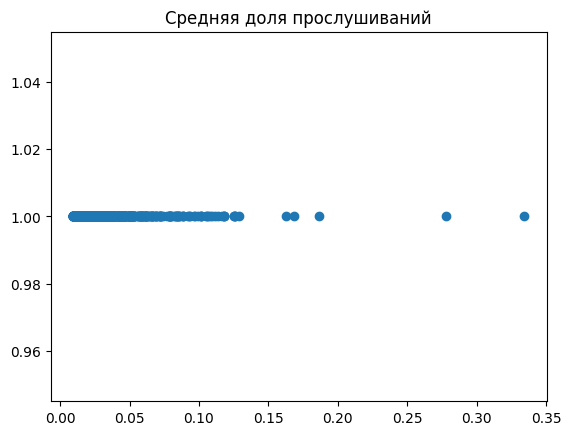

In [158]:
plt.scatter(np.mean(ratings > 0, axis=1), np.ones(1000,))
plt.title('Средняя доля прослушиваний')
plt.show()

In [160]:
np.mean(ratings, axis=1)

the beatles           0.018369
radiohead             0.011851
deathcab for cutie    0.006543
coldplay              0.006030
modest mouse          0.005876
                        ...   
michal w. smith       0.000895
群星                    0.000519
agalloch              0.000997
meshuggah             0.000431
yellowcard            0.000320
Length: 1000, dtype: float64

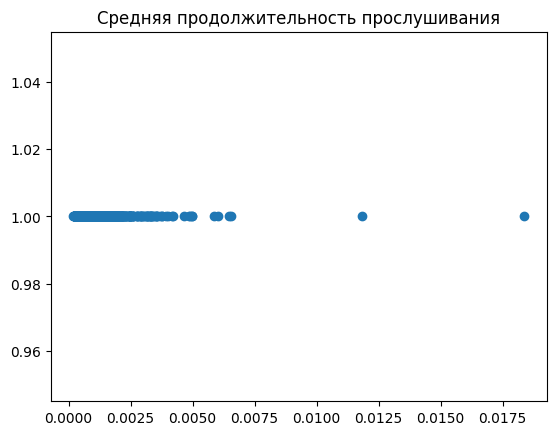

In [157]:
import matplotlib.pyplot as plt
plt.scatter(np.mean(ratings, axis=1), np.ones(1000,))
plt.title('Средняя продолжительность прослушивания')
plt.show()

**Ответ:** ответ заключается в том, что The Beatles очень популярная группа, ее слушают много людей, около 33 % всех пользователей, также ее в среднем слушают дольше всех, что видно на вышеприведенных графиках

## Задание 4 (0.5 балла) Улучшение кластеризации

Попытаемся избавиться от этой проблемы: нормализуйте данные при помощи `normalize`.

In [35]:
from sklearn.preprocessing import normalize
ratings_normalized = normalize(ratings)
ratings_normalized = pd.DataFrame(ratings_normalized, index=ratings.index)

Примените KMeans с 5ю кластерами на преобразованной матрице, посмотрите на их размеры. Стало ли лучше? Может ли кластеризация быть полезной теперь?

In [11]:
from sklearn.cluster import KMeans
import numpy as np
kmeans = KMeans(n_clusters=5)
kmeans.fit(ratings_normalized)
labels = kmeans.labels_
np.unique(labels, return_counts=True)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


(array([0, 1, 2, 3, 4], dtype=int32), array([260,  62, 104, 180, 394]))

**Ответ** конечно стало лучше, теперь есть более менее нормальный баланс по кластерам и разметка будет более полезной при рекомандации или классификации.

## Задание 5 (1 балл) Центроиды

Выведите для каждого кластера названия топ-10 исполнителей, ближайших к центроиду по косинусной мере. Проинтерпретируйте результат. Что можно сказать о смысле кластеров?

In [9]:
from scipy.spatial.distance import cosine


centroids = kmeans.cluster_centers_
centroids.shape

(5, 5000)

In [41]:
ratings_normalized.apply(lambda x: cosine(x, centroids[0]), axis=1).sort_values(ascending=True)[:10].index

Index(['metallica', 'system of a down', 'koЯn', 'mudvayne', 'iron maiden',
       'disturbed', 'tool', 'megadeth', 'slayer', 'marilyn manson'],
      dtype='object')

In [42]:
ratings_normalized.apply(lambda x: cosine(x, centroids[1]), axis=1).sort_values(ascending=True)[:10].index

Index(['animal collective', 'radiohead', 'broken social scene',
       'the arcade fire', 'belle and sebastian', 'sufjan stevens',
       'of montreal', 'sonic youth', 'beirut', 'the shins'],
      dtype='object')

In [43]:
ratings_normalized.apply(lambda x: cosine(x, centroids[2]), axis=1).sort_values(ascending=True)[:10].index

Index(['nas', 'jay-z', 'kanye west', 'lupe the gorilla',
       'a tribe called quest', 'the roots featuring d'angelo',
       'little brother', 'lil' wayne', 'the game', 'mos def'],
      dtype='object')

In [44]:
ratings_normalized.apply(lambda x: cosine(x, centroids[3]), axis=1).sort_values(ascending=True)[:10].index

Index(['the beatles', 'radiohead', 'the rolling stones', 'dylan. bob',
       'white stripes', 'led zeppelin.', 'beck', 'pink fluid', 'u2', 'r.e.m.'],
      dtype='object')

In [45]:
ratings_normalized.apply(lambda x: cosine(x, centroids[4]), axis=1).sort_values(ascending=True)[:10].index

Index(['fall out boy', 'brand new', 'blink-182', 'dashboard confesssional',
       'paramore', 'taking back sunday', 'deathcab for cutie',
       'jimmy eat world', 'new found glory', 'cartel'],
      dtype='object')

**Ответ:** результат очень легкоинтерпретируемый: видно, что каждый кластер - это особый ярковыделяющийся жанр музыки, например: тяжелый рок, софт рок, попса и так далее

## Задание 6 (1 балл) Визуализация

Хотелось бы как-то визуализировать полученную кластеризацию. Постройте точечные графики `plt.scatter` для нескольких пар признаков исполнителей, покрасив точки в цвета кластеров. Почему визуализации получились такими? Хорошо ли они отражают разделение на кластеры? Почему?

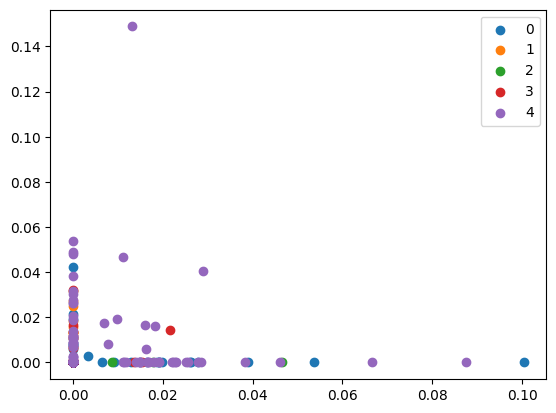

In [59]:
import matplotlib.pyplot as plt

#Getting unique labels

u_labels = np.unique(labels)

#plotting the results:

for i in u_labels:
    plt.scatter(ratings_normalized[labels == i][2663] , ratings_normalized[labels == i][1812] , label = i)
plt.legend()
plt.show()

код [отсюда](https://www.askpython.com/python/examples/plot-k-means-clusters-python)

**Ответ:** визуализация плохая, очень сложно отследить положение объктов по разным кластерам всего по 2 пользователям, так как они скорее всего предпочитают какой-то один жанр музыки, и вообще слушают они немного песен

Для визуализации данных высокой размерности существует метод t-SNE (стохастическое вложение соседей с t-распределением). Данный метод является нелинейным методом снижения размерности: каждый объект высокой размерности будет моделироваться объектов более низкой (например, 2) размерности таким образом, чтобы похожие объекты моделировались близкими, непохожие - далекими с большой вероятностью.

Примените `TSNE` из библиотеки `sklearn` и визуализируйте полученные объекты, покрасив их в цвета их кластеров

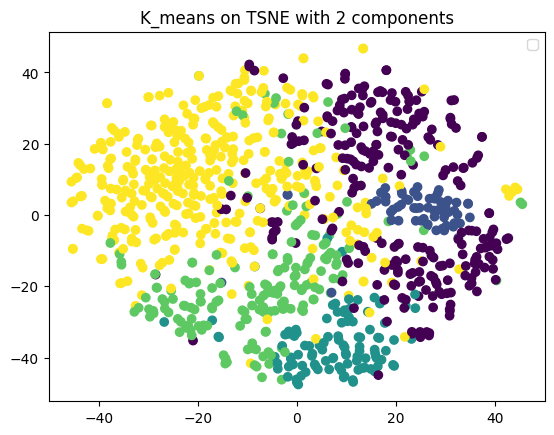

In [61]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, init = 'random')
projections = tsne.fit_transform(ratings_normalized)
plt.scatter(projections[:,0], projections[:,1], c = labels)
plt.title('K_means on TSNE with 2 components')
plt.legend()
plt.show()

## Задание 7 (1 балл) Подбор гиперпараметров

Подберите оптимальное количество кластеров (максимум 100 кластеров) с использованием индекса Силуэта. Зафиксируйте `random_state=42`

In [64]:
from sklearn.metrics import silhouette_score
n_clusters = [2, 5, 15, 30, 50, 75, 100]
for n in n_clusters:
  kmeans = KMeans(n_clusters=n, random_state=42)
  print(silhouette_score(ratings_normalized, kmeans.fit_predict(ratings_normalized)), n)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


0.004435467122570446 2


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


0.006837938191539542 5


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


0.007925642156739573 15


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


0.006523738685078842 30


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


0.007794560503016977 50


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


0.011129769788390862 75


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


0.01534593257458335 100


Ну значит 100 кластеров будет

Выведите исполнителей, ближайших с центроидам (аналогично заданию 5). Как соотносятся результаты? Остался ли смысл кластеров прежним? Расскажите про смысл 1-2 интересных кластеров, если он изменился и кластеров слишком много, чтобы рассказать про все.

In [68]:
centroids = kmeans.cluster_centers_

In [69]:
ratings_normalized.apply(lambda x: cosine(x, centroids[34]), axis=1).sort_values(ascending=True)[:10].index

Index(['tool', 'perfect circle', 'niИ', 'ratm', 'porcupine tree', 'dredg',
       'faith no more', 'tencacious d', 'ВИВАЛЬДИ', 'marilyn manson'],
      dtype='object')

In [70]:
ratings_normalized.apply(lambda x: cosine(x, centroids[2]), axis=1).sort_values(ascending=True)[:10].index

Index(['wilco', 'yo la tengo', 'okkervil river', 'm. ward', 'the flaming lips',
       'nick drake', 'wolf parade', 'sun kil moon', 'm.i.a.*', 'the walkmen'],
      dtype='object')

In [71]:
ratings_normalized.apply(lambda x: cosine(x, centroids[76]), axis=1).sort_values(ascending=True)[:10].index

Index(['joanna newsom', 'the microphones', 'mirah', 'múm', 'patrick wolf',
       'regina spektor', 'final fantasy6', 'devendra banhart',
       'the mountain goats', 'björk guğmunsdóttir'],
      dtype='object')

In [72]:
ratings_normalized.apply(lambda x: cosine(x, centroids[0]), axis=1).sort_values(ascending=True)[:10].index

Index(['louıs armstrong', 'Ｂille holiday', 'ray charles', 'the band',
       'duke ellington', 'nina simone', 'reinhardt, django', 'buddy holly',
       'ella fitzgerald', 'miles davis.'],
      dtype='object')

**Ответ:** ну вообще мы сейчас преследовали цель как можно лучший score, поэтому с интерпретацией будет посложнее, уже не так легко все разбивается по жанрам, и самые близкие к центроидам артисты гораздо менее известны.

Однако, все таки есть хорошо отличимые примеры (но я для этого погуглила артистов), например, близкие к центроиду с индексом 0 - там находятся артисты связанные с классической музыкой и эстрадным пением.

Сделайте t-SNE визуализацию полученной кластеризации.

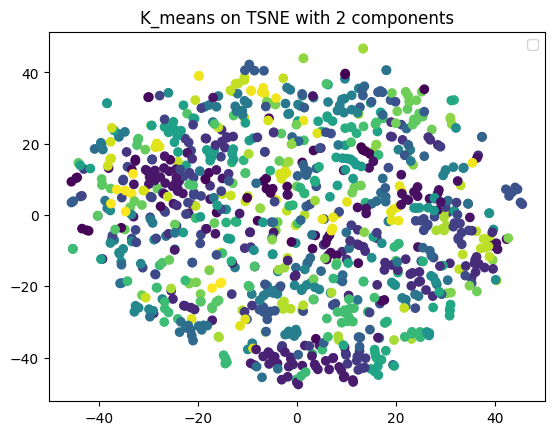

In [73]:
plt.scatter(projections[:,0], projections[:,1], c = kmeans.labels_)
plt.title('K_means on TSNE with 2 components')
plt.legend()
plt.show()

Если кластеров получилось слишком много и визуально цвета плохо отличаются, покрасьте только какой-нибудь интересный кластер из задания выше (`c = (labels == i)`). Хорошо ли этот кластер отражается в визуализации?

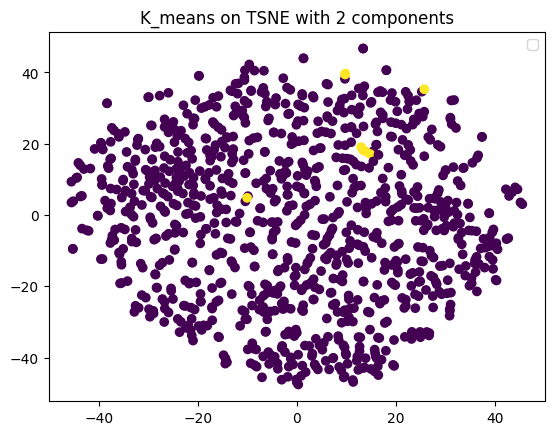

In [75]:
plt.scatter(projections[:,0], projections[:,1], c = (kmeans.labels_ == 0))
plt.title('K_means on TSNE with 2 components')
plt.legend()
plt.show()

**Ответ:** ну не прям, чтобы вау, хотя какая-то кучка с очень высокой плотностью находится по координатам (15, 19)